# co

> Covariance and Coherence Matrix Estimation

In [ ]:
#| default_exp cli/co

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import math

import zarr
import cupy as cp
import numpy as np
from matplotlib import pyplot as plt
import colorcet

import dask
from dask import array as da
from dask import delayed
from dask.distributed import Client, LocalCluster
from dask_cuda import LocalCUDACluster

from decorrelation.co import emperical_co_pc
from decorrelation.cli.utils.logging import get_logger, log_args
from decorrelation.cli.utils.dask import pad_internal, get_cuda_cluster
from decorrelation.cli.utils.chunk_size import get_pc_chunk_size_from_n_az_chunk

from fastcore.script import call_parse

In [ ]:
#| export
@call_parse
@log_args
def de_emperical_co_pc(rslc:str, # input: rslc stack
                       ds_can_is_shp:str, # input: bool array indicating the SHPs of every pixel
                       ds_can_idx:str, # input: bool array indicating DS candidate
                       ds_can_coh:str, # output: complex coherence matrix for DS candidate
                       az_chunk_size:int=None, # azimuth chunk size, optional. Default: the azimuth chunk size in rslc stack
                       n_pc_chunk:int=None, # number of point chunk, optional.
                       pc_chunk_size:int=None, # chunk size of output zarr dataset, optional. Default: same as ds_can_is_shp
                       ds_can_coh_ave_fig:str=None, # path to the plot of average coherence matrix of DS candidate, optional. Default: no plot
                       log=None, # log file. Default: no log file
                       ):
    '''estimate emperical coherence matrix on point cloud data.
    Only one of `n_pc_chunk` and `pc_chunk_size` needs to be setted. The other one is automatically determined.
    If all of them are not setted, the `n_pc_chunk` will be setted as the number of azimuth chunks.
    '''
    rslc_path = rslc
    ds_can_is_shp_path = ds_can_is_shp
    ds_can_idx_path = ds_can_idx
    ds_can_coh_path = ds_can_coh
    logger = get_logger(logfile=log)

    rslc_zarr = zarr.open(rslc_path,mode='r')
    logger.zarr_info(rslc_path, rslc_zarr)
    assert rslc_zarr.ndim == 3, "rslc dimentation is not 3."

    ds_can_is_shp_zarr = zarr.open(ds_can_is_shp_path,mode='r')
    logger.zarr_info(ds_can_is_shp_path, ds_can_is_shp_zarr)
    assert ds_can_is_shp_zarr.ndim == 3, "ds_can_is_shp dimentation is not 3."

    ds_can_idx_zarr = zarr.open(ds_can_idx_path,mode='r')
    logger.zarr_info(ds_can_idx_path, ds_can_idx_zarr)
    assert ds_can_idx_zarr.ndim == 2, "ds_can_idx dimentation is not 2."
    logger.info('loading ds_can_idx into memory.')
    ds_can_idx = zarr.open(ds_can_idx_path,mode='r')[:]

    az_win, r_win = ds_can_is_shp_zarr.shape[1:]
    az_half_win = int((az_win-1)/2)
    r_half_win = int((r_win-1)/2)
    logger.info(f'got azimuth window size and half azimuth window size from is_shp shape: {az_win}, {az_half_win}')
    logger.info(f'got range window size and half range window size from is_shp shape: {r_win}, {r_half_win}')

    if not az_chunk_size:
        az_chunk_size = rslc_zarr.chunks[0]
        logger.info('using default parallel processing azimuth chunk size from rslc dataset.')
    logger.info('parallel processing azimuth chunk size: '+str(az_chunk_size))

    logger.info('starting dask CUDA local cluster.')
    cluster, client = get_cuda_cluster()
    logger.info('dask local CUDA cluster started.')

    logger.info('create raster bool array is_ds_can from ds_can_idx')
    np_is_ds_can = np.zeros(rslc_zarr.shape[:2],dtype=bool)
    np_is_ds_can[(ds_can_idx[0],ds_can_idx[1])] = True
    logger.info('create dask bool array is_ds_can')
    cpu_is_ds_can = da.from_array(np_is_ds_can,chunks=(az_chunk_size,-1))
    logger.darr_info('is_ds_can', cpu_is_ds_can)
    
    logger.info('Using azimuth chunk size as the processing chunk size.')
    logger.info('Calculate point chunk size')
    cpu_ds_can_idx = da.nonzero(cpu_is_ds_can)
    idx_0 = cpu_ds_can_idx[0]
    process_pc_chunk_size = idx_0.compute_chunk_sizes().chunks[0]
    logger.info(f'Point chunk size: {process_pc_chunk_size}')

    cpu_rslc = da.from_zarr(rslc_path,chunks=(az_chunk_size,*rslc_zarr.shape[1:]))
    logger.darr_info('rslc', cpu_rslc)

    cpu_ds_can_is_shp = da.from_zarr(ds_can_is_shp_path,chunks=(process_pc_chunk_size,*ds_can_is_shp_zarr.shape[1:]))
    logger.darr_info('ds_can_is_shp', cpu_ds_can_is_shp)

    depth = {0:az_half_win, 1:r_half_win, 2:0}; boundary = {0:'none',1:'none',2:'none'}
    cpu_rslc_overlap = da.overlap.overlap(cpu_rslc,depth=depth, boundary=boundary)
    logger.info('setting shared boundaries between rlsc chunks.')
    logger.darr_info('rslc_overlap', cpu_rslc_overlap)

    depth = {0:az_half_win, 1:r_half_win}
    cpu_is_ds_can_padded = pad_internal(cpu_is_ds_can,depth=depth)
    logger.info('padding zero between is_ds_can chunks.')
    logger.darr_info('is_ds_can_padded', cpu_is_ds_can_padded)

    logger.info(f'estimating coherence matrix.')
    rslc_overlap = cpu_rslc_overlap.map_blocks(cp.asarray)
    is_ds_can_padded = cpu_is_ds_can_padded.map_blocks(cp.asarray)
    ds_can_is_shp = cpu_ds_can_is_shp.map_blocks(cp.asarray)
    
    emperical_co_pc_delayed = delayed(emperical_co_pc,pure=True,nout=2)

    is_ds_can_padded_delayed = is_ds_can_padded.to_delayed()
    is_ds_can_padded_delayed = np.squeeze(is_ds_can_padded_delayed,axis=-1)
    rslc_overlap_delayed = rslc_overlap.to_delayed()
    rslc_overlap_delayed = np.squeeze(rslc_overlap_delayed,axis=(-2,-1))
    ds_can_is_shp_delayed = ds_can_is_shp.to_delayed()
    ds_can_is_shp_delayed = np.squeeze(ds_can_is_shp_delayed,axis=(-2,-1))

    ds_can_coh_delayed = np.empty_like(rslc_overlap_delayed,dtype=object)
    ds_can_idx_delayed = np.empty_like(rslc_overlap_delayed,dtype=object)

    nimage = rslc_overlap.shape[-1]
    with np.nditer(rslc_overlap_delayed,flags=['multi_index','refs_ok'], op_flags=['readwrite']) as it:
        for block in it:
            idx = it.multi_index
            ds_can_idx_delayed[idx] = delayed(cp.where)(is_ds_can_padded_delayed[idx])
            ds_can_coh_delayed[idx] = emperical_co_pc_delayed(rslc_overlap_delayed[idx],ds_can_idx_delayed[idx],ds_can_is_shp_delayed[idx])[1]
            chunk_shape = (ds_can_is_shp.blocks[idx].shape[0],nimage,nimage)
            dtype = rslc_overlap.dtype
            ds_can_coh_delayed[idx] = da.from_delayed(ds_can_coh_delayed[idx],shape=chunk_shape,meta=cp.array((),dtype=dtype))

    ds_can_coh = da.block(ds_can_coh_delayed.reshape(*ds_can_coh_delayed.shape,1,1).tolist())
    cpu_ds_can_coh = ds_can_coh.map_blocks(cp.asnumpy)
    logger.info(f'got coherence matrix.')

    # zarr do not support irregular chunk size
    pc_chunk_size = get_pc_chunk_size_from_n_az_chunk('rslc','ds_can_coh',cpu_rslc.shape[0],az_chunk_size,ds_can_coh.shape[0],logger,pc_chunk_size=pc_chunk_size,n_pc_chunk=n_pc_chunk)
    cpu_ds_can_coh = cpu_ds_can_coh.rechunk((pc_chunk_size,nimage,nimage))
    logger.info('rechunking ds_can_coh to chunk size (for saving with zarr): '+str(cpu_ds_can_coh.chunksize))

    logger.info('saving ds_can_coh.')
    _cpu_ds_can_coh = cpu_ds_can_coh.to_zarr(ds_can_coh_path,overwrite=True,compute=False)

    cpu_ds_can_coh_ave = da.abs(cpu_ds_can_coh).mean(axis=0)

    logger.info('computing graph setted. doing all the computing.')
    #This function is really slow just because the coherence is very big and rechunk and saving takes too much time.
    # I do not find any solution to it.
    cpu_ds_can_coh_ave_result = da.compute(_cpu_ds_can_coh,cpu_ds_can_coh_ave)[1]

    # pdb.set_trace()
    logger.info('computing finished.')
    cluster.close()
    logger.info('dask cluster closed.')

    if ds_can_coh_ave_fig:
        logger.info('plotting average coherence matrix.')
        fig, ax = plt.subplots(1,1,figsize=(15,10))
        pcm = ax.imshow(cpu_ds_can_coh_ave_result,cmap=colorcet.cm.fire)
        ax.set(title='Average Coherence Matrix',xlabel='Image Index',ylabel='Image Index')
        fig.colorbar(pcm)
        fig.show()
        fig.savefig(ds_can_coh_ave_fig)

In [ ]:
rslc = './raw/rslc.zarr'
ds_can_is_shp = './shp/ds_can_is_shp.zarr'
ds_can_idx = './shp/ds_can_idx.zarr'
ds_can_coh = './co/ds_can_coh.zarr'
az_chunk_size = 1000
pc_chunk_size = None
log = './co/co.log'
ds_can_coh_ave_fig = './co/ds_can_coh_ave.png'

2023-10-18 17:21:59 - de_emperical_co_pc - INFO - fetching args:
2023-10-18 17:21:59 - de_emperical_co_pc - INFO - rslc = './raw/rslc.zarr'
2023-10-18 17:21:59 - de_emperical_co_pc - INFO - ds_can_is_shp = './shp/ds_can_is_shp.zarr'
2023-10-18 17:21:59 - de_emperical_co_pc - INFO - ds_can_idx = './shp/ds_can_idx.zarr'
2023-10-18 17:21:59 - de_emperical_co_pc - INFO - ds_can_coh = './co/ds_can_coh.zarr'
2023-10-18 17:21:59 - de_emperical_co_pc - INFO - az_chunk_size = None
2023-10-18 17:21:59 - de_emperical_co_pc - INFO - n_pc_chunk = None
2023-10-18 17:21:59 - de_emperical_co_pc - INFO - pc_chunk_size = None
2023-10-18 17:21:59 - de_emperical_co_pc - INFO - ds_can_coh_ave_fig = './co/ds_can_coh_ave.png'
2023-10-18 17:21:59 - de_emperical_co_pc - INFO - log = './co/co.log'
2023-10-18 17:21:59 - de_emperical_co_pc - INFO - fetching args done.
2023-10-18 17:21:59 - de_emperical_co_pc - INFO - ./raw/rslc.zarr zarray shape: (2500, 1834, 17)
2023-10-18 17:21:59 - de_emperical_co_pc - INFO - 

2023-10-18 17:22:01,720 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-10-18 17:22:01,720 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize
2023-10-18 17:22:01,722 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-10-18 17:22:01,722 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize
2023-10-18 17:22:01,734 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-10-18 17:22:01,734 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize
2023-10-18 17:22:01,746 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-10-18 17:22:01,746 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize
2023-10-18 17:22:01,750 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-10-18 17:22:01,750 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize
2023-

2023-10-18 17:22:07 - de_emperical_co_pc - INFO - dask local CUDA cluster started.
2023-10-18 17:22:07 - de_emperical_co_pc - INFO - create raster bool array is_ds_can from ds_can_idx
2023-10-18 17:22:07 - de_emperical_co_pc - INFO - create dask bool array is_ds_can
2023-10-18 17:22:07 - de_emperical_co_pc - INFO - is_ds_can dask array shape: (2500, 1834)
2023-10-18 17:22:07 - de_emperical_co_pc - INFO - is_ds_can dask array chunksize: (1000, 1834)
2023-10-18 17:22:07 - de_emperical_co_pc - INFO - is_ds_can dask array dtype: bool
2023-10-18 17:22:07 - de_emperical_co_pc - INFO - Using azimuth chunk size as the processing chunk size.
2023-10-18 17:22:07 - de_emperical_co_pc - INFO - Calculate point chunk size
2023-10-18 17:22:07 - de_emperical_co_pc - INFO - Point chunk size: (346329, 274921, 119147)
2023-10-18 17:22:07 - de_emperical_co_pc - INFO - rslc dask array shape: (2500, 1834, 17)
2023-10-18 17:22:07 - de_emperical_co_pc - INFO - rslc dask array chunksize: (1000, 1834, 17)
2023-

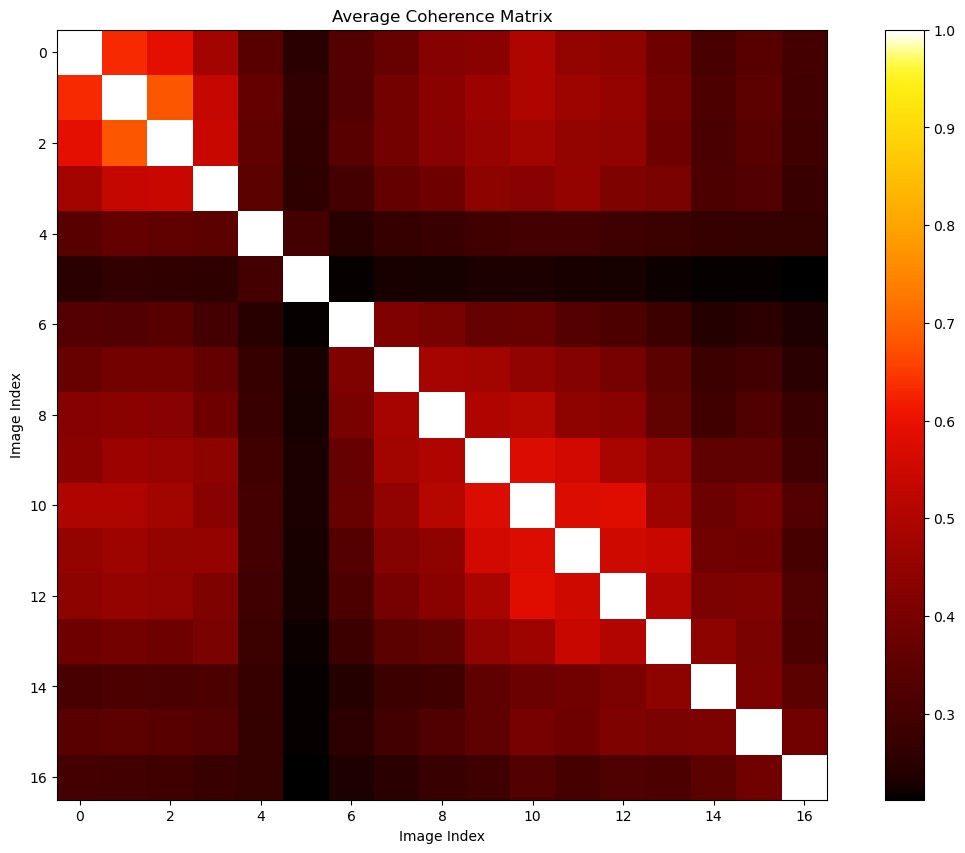

In [ ]:
%%time
de_emperical_co_pc(rslc,ds_can_is_shp,ds_can_idx,ds_can_coh,log=log,ds_can_coh_ave_fig=ds_can_coh_ave_fig)

In [ ]:
!de_emperical_co_pc -h

usage: de_emperical_co_pc [-h] [--az_chunk_size AZ_CHUNK_SIZE]
                          [--n_pc_chunk N_PC_CHUNK]
                          [--pc_chunk_size PC_CHUNK_SIZE]
                          [--ds_can_coh_ave_fig DS_CAN_COH_AVE_FIG] [--log LOG]
                          rslc ds_can_is_shp ds_can_idx ds_can_coh

estimate emperical coherence matrix on point cloud data. Only one of
`n_pc_chunk` and `pc_chunk_size` needs to be setted. The other one is
automatically determined. If all of them are not setted, the `n_pc_chunk` will
be setted as the number of azimuth chunks.

positional arguments:
  rslc                                  input: rslc stack
  ds_can_is_shp                         input: bool array indicating the SHPs of
                                        every pixel
  ds_can_idx                            input: bool array indicating DS
                                        candidate
  ds_can_coh                            output: complex coherence matrix for DS
  

In [ ]:
%%time
#| hide
import numpy as np
import zarr
import cupy as cp
from decorrelation.shp import ks_test
rslc_zarr = zarr.open('./raw/rslc.zarr',mode='r')
ds_can_is_shp_zarr = zarr.open('./shp/ds_can_is_shp.zarr','r')
ds_can_idx_zarr = zarr.open('./shp/ds_can_idx.zarr','r')

rslc_cpu = rslc_zarr[:]; rslc = cp.asarray(rslc_cpu)
ds_can_is_shp_cpu = ds_can_is_shp_zarr[:]; ds_can_is_shp = cp.asarray(ds_can_is_shp_cpu)
ds_can_idx_cpu = ds_can_idx_zarr[:]; ds_can_idx = cp.asarray(ds_can_idx_cpu)

ds_can_coh = emperical_co_pc(rslc,ds_can_idx,ds_can_is_shp)[1]

ds_can_coh_cpu = cp.asnumpy(ds_can_coh)
nimage = rslc.shape[-1]
ds_can_chunk_size = math.ceil(ds_can_coh.shape[0]/3)
test_ds_can_coh_zarr = zarr.open('./co/test_ds_can_coh.zarr','w',shape=ds_can_coh_cpu.shape,chunks=(ds_can_chunk_size,nimage,nimage),dtype=ds_can_coh_cpu.dtype)
test_ds_can_coh_zarr[:] = ds_can_coh_cpu

CPU times: user 3.9 s, sys: 2.88 s, total: 6.79 s
Wall time: 4.91 s


In [ ]:
#| hide
ds_can_coh_result = zarr.open('./co/ds_can_coh.zarr','r')[:]
ds_can_coh_test = zarr.open('./co/test_ds_can_coh.zarr','r')[:]
np.testing.assert_array_equal(ds_can_coh_cpu,ds_can_coh_result)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()